# Exercises: Hands on DNN and 1DCNN

In [1]:
#Loading some useful libraries discussed in previous sessions of the hackathon

# OS is the built-in python library for exploring the file system
## from Standard Python Library
import os 
import math

# Numpy, Pandas and matplotlib are must have libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#  Image processing libraries

from PIL import Image, ImageOps 
from mpl_toolkits.axes_grid1 import ImageGrid

# Machine learning libraries 

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import tensorflow as tf
import keras

# GPU usage; see https://www.tensorflow.org/guide/gpu
print('Check on not using GPU through TensorFlow\n')

gpus = tf.config.list_physical_devices('GPU')
assert len(gpus) == 0, "Using GPU is disabled by default."

Check on not using GPU through TensorFlow



## Exercise 0: Data preprocessing using numpy

In the lecture we skipped a crucial step, which precedes the training process: the data preprocessing. 

It is a fundamental step to standardize and uniformize data, which ultimately leads to a better training process. 

<img src="./Assets/Images/data_preprocessing.png" alt="Drawing" style="width: 65%"/>

In particular, here we should normalize the data (so that the count per histogram per pixel are normalized to lie in the $[0,1)$ interval). 

This exercise is quite introductory and it doesn't need any knowledge on Machine Learning; it is an introductory exercise where people may text their fluidity in the use of numpy.

**EXERCISE**

Import the data and standardize them, following the steps:
1. Compute the number of counts per pixel (i.e. for each row of the dataset);
2. Compute the mean and standard deviation for each pixel
3. Create a new, preprocessed X_train (X_test) where the new array values have zero mean, uniform standard deviation and they sum to 1. 

If you feel comfortable about it, you may define a custom ah-hoc python class for this pre-processing process

In [2]:
# Import dataset: pick a path to .csv file
path = 'Training_dataset/dataset.csv'

# Use pandas to import csv
df_train_dataset = pd.read_csv(path, index_col=0)

# Transform the strings representing the histograms into lists
df_train_dataset['X'] = df_train_dataset['X'].str[1:-1].str.split(" ")
df_train_dataset['y'] = df_train_dataset['y'].str[1:-1].str.split(" ")

# Transfrom the lists into arrays, cleaning empty entries 
hists = []
rgbs  = []
from tqdm import tqdm 
for idx_, (X, y) in tqdm(df_train_dataset[['X', 'y']].iterrows(), total=len(df_train_dataset), desc="Loading..."):
    hists.append (np.array([float(v) for v in X if v not in ["\n", "", " "]]))
    rgbs.append (np.array([float(v) for v in y if v not in ["\n", "", " "]]))   
    
hists = np.array(hists)
rgbs = np.array(rgbs)
del df_train_dataset

def prepare_training_dataset(X, y, percentage = 0.8):
    # Shuffle the dataframe
    assert len(X)==len(y), "Inconsistent number of rows in X and y"
    
    N = len(X)
    indices = np.random.permutation (N)
    
    n = int(N*percentage)
    train = indices[:n]
    test = indices[n:]
    
    return X[train], y[train], X[test], y[test]

X_train, y_train, X_test, y_test = prepare_training_dataset(hists, rgbs, percentage = 0.8)

print('Train elements: ', np.shape(X_train) )
print('Test Elements: ', np.shape(X_test) )

print('Train/test features: ', len(X_train[0]) )
print(f'Shape X_train: {(np.shape(X_train)[0], np.shape(X_train)[1]) }')
print(f'Shape y_train: {(np.shape(y_train)[0], np.shape(y_train)[1]) }')

Loading...: 100%|██████████| 25974/25974 [00:07<00:00, 3489.11it/s]


Train elements:  (20779, 500)
Test Elements:  (5195, 500)
Train/test features:  500
Shape X_train: (20779, 500)
Shape y_train: (20779, 3)


Compute Dataset properties:
Preprocess data:
Unnormalized:
Check the mean: -1.9392971221807933e-19
Check the standard deviation: 0.9202585343806569
Show Original vs preprocessed:


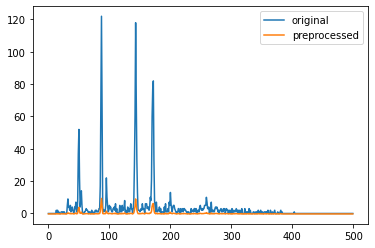

Show only preprocessed:


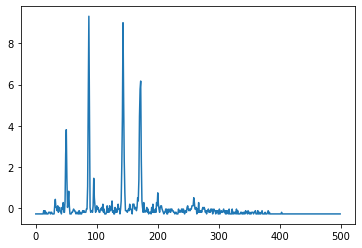

In [3]:
print('Compute Dataset properties:')
train_mean_array = np.mean(X_train.T, axis=0)
train_std_array = np.std(X_train.T, axis=0)

print("Preprocess data:")
X_train_preprocessed = ( (X_train.T - train_mean_array)/(train_std_array + 1) )
X_train_preprocessed = np.array(X_train_preprocessed.T)

print('Unnormalized:')
print(f"Check the mean: {X_train_preprocessed.mean(axis=1).mean()}")
print(f"Check the standard deviation: {X_train_preprocessed.std(axis=1).mean()}")

print("Show Original vs preprocessed:")
plt.plot(range(0, 500), X_train[0], label='original')
plt.plot(range(0, 500), X_train_preprocessed[0], label='preprocessed')
plt.legend()
plt.show()

print("Show only preprocessed:")
plt.plot(range(0, 500), X_train_preprocessed[0])
plt.show()

Unnormalized:
Check the mean: -3.0949356899471677e-21
Check the standard deviation: 0.007621713896887652
Show Original vs preprocessed vs normalized:


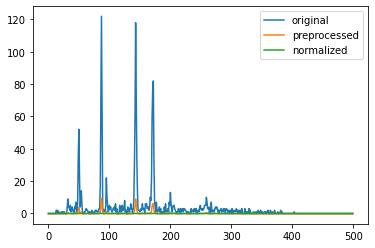

Show only normalized:


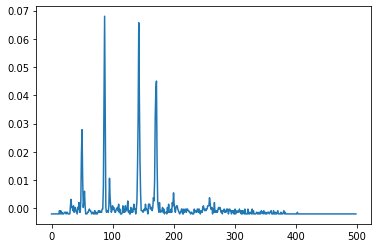

In [4]:
n_of_counts = np.sum(X_train.T, axis=0) + 1e-8
train_mean_array = np.mean(X_train.T/n_of_counts, axis=0)
train_std_array = np.std(X_train.T/n_of_counts, axis=0)

X_train_pre_norm = X_train.T/n_of_counts
X_train_pre_norm = ( (X_train_pre_norm - train_mean_array)/(train_std_array + 1) )
X_train_pre_norm = np.array(X_train_pre_norm.T)

print('Unnormalized:')
print(f"Check the mean: {X_train_pre_norm.mean(axis=1).mean()}")
print(f"Check the standard deviation: {X_train_pre_norm.std(axis=1).mean()}")

print("Show Original vs preprocessed vs normalized:")
plt.plot(range(0, 500), X_train[0], label='original')
plt.plot(range(0, 500), X_train_preprocessed[0], label='preprocessed')
plt.plot(range(0, 500), X_train_pre_norm[0], label='normalized')
plt.legend()
plt.show()

print("Show only normalized:")
plt.plot(range(0, 500), X_train_pre_norm[0])
plt.show()

In [5]:
class Preprocessor:
    def __init__ (self, dataset):
        self._n_photons = np.sum(dataset, axis=1)
        self._mean = np.mean (dataset.T, axis=0)
        self._std = np.std (dataset.T, axis=0)
        
    def transform (self, X):
        return_x = ((X.T - self._mean)/(self._std + 1))
        return return_x.T
    
    def transform_normalized (self, X):
        return_x = ((X.T - self._mean)/(self._std + 1))/(self._n_photons + 1e-7)
        return return_x.T

preprocessor = Preprocessor(X_train)

## Exercise 1: Counteract Overfitting - DropOut layers

<img src="./Assets/Images/overfitting_1.png" alt="Drawing" style="float: center; margin-top: 15px"/>

In statistics, overfitting is:

*"the production of an analysis that corresponds too closely or exactly to a particular set of data, and may therefore fail to fit additional data or predict future observations reliably."*

<img src="./Assets/Images/overfitting-comics.jpg" alt="Drawing" style="float: center; margin-top: 15px"/>

In machine learning models (which are statistical models), overfitting appears when there is an umbalance between the number of trainable parameters and the size of the training dataset; it becomes manifest during the training process when the model performs poorly on the test/validation dataset, w.r.t. the training dataset, i.e. when the validation scores starts increasing in epochs, while training scores still decreases

<img src="./Assets/Images/overfitting_2.png" alt="Drawing" style="float: center; margin-top: 15px; width: 400px"/>

A way to counteract this event in Deep Neural Networks is to add **drop layers** in the DNN architecture. [2], [3], [4]

Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel. During training, some number of layer outputs are randomly ignored or “dropped out”. Dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs.

<img src="./Assets/Images/DropLayer.gif" alt="Drawing" style="float: center; margin-top: 15px;"/>

In Keras, dropout layers are asily implemented by the *Dropout* class [5]

tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, **kwargs)

that:

*The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.*

**EXERCISE**

Build a Deep Dense Neural Network with (at least) 5 layers, and apply it to our model. (Keep an eye on the number of parameters, and on how long does it take to train an epoch).

See if it shows overfitting; if not, deepen it, until it shows it. 

Then, create a new network with Dense layers, and see if it is now free of overfitting. 

-------
[1] https://www.lexico.com/definition/overfitting

[2] https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

[3] https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/

[4] N. Srivastava, G. Hinton, A. Krizhevsky, I. Sutskever, R. Salakhutdinov, *Dropout: A Simple Way to Prevent Neural Networks from Overfitting* https://jmlr.org/papers/v15/srivastava14a.html

[5] https://keras.io/api/layers/regularization_layers/dropout/

In [6]:
#######################################################################################################################
# Import relevant Keras classes

# Input layer 
from keras.layers import InputLayer, Input
# The Dense Layer
from keras.layers import Dense
# Utilities
from keras.layers import Flatten, MaxPooling1D, Dropout, AveragePooling1D, GlobalAveragePooling1D, Reshape

# Sequential class for instantiating the Model
from keras.models import Sequential
from keras import Model # If we want to use the Keras API

# To get the Activation functions
from keras.layers import Activation


#######################################################################################################################
# Input-Output defs

input_shape = np.shape(X_train)[1]   # Input layer takes [number of vectors, size of vectors, features-per-vector] = [#size_dataset, 1000, 1]
num_classes = 3 # RGB

CHANNEL_DEPTH = 500   # Each histograms has 500 channels
num_sensors = 1       # We have only 1 histogram per data

#######################################################################################################################
# Defining the model
#######################################################################################################################

# Instantiate it
model_m = Sequential()

#############
# input
model_m.add(Input(shape=(input_shape, )))

#############
# Hidden Layers

# 1°
model_m.add(Dense(128,
                 activation='relu'))
# 2°
model_m.add(Dense(256,
                 activation='relu'))
# 3° 
model_m.add(Dense(128,
                 activation='relu'))
# 4° 
model_m.add(Dense(256,
                 activation='relu'))
# 5°
model_m.add(Dense(128,
                 activation='relu'))

# Output layer
model_m.add(Dense(num_classes, activation='sigmoid'))

###########
# Summary
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               64128     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 196,355
Trainable params: 196,355
Non-trainable params: 0
__________________________________________________

In [7]:
############################
# Training - prerequisites
loss_used = 'binary_crossentropy'

model_m.compile(loss=loss_used,
                 optimizer='adam',
                 )
# We need to pick the size of the batch used for the training
BATCH_SIZE = 200 
# And the number of epochs on which we train the dataset
EPOCHS = 20 

import datetime
starting_time = datetime.datetime.now() 

print('\nStart training model: \n')

##########################################################
# TRAINING

history = model_m.fit(X_train,
                       y_train,
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,plt.hist (X_train.sum(axis=1), bins=np.linspace(0, 3000, 300))
plt.xlabel ("Number of photons")
plt.ylabel ("Number of pixels")
plt.show()

plt.hist (X_train.flatten(), bins=np.linspace(0, 500, 501))
plt.xlabel ("Number of photons")
plt.ylabel ("Number of ADC channels per pixel")
plt.yscale ('log')
plt.show()
                       #callbacks=callbacks_list,
                       validation_data=(X_test, y_test),
                       verbose=1)

print('\n\nTraining done...\n')

now = datetime.datetime.now()
total_training_time = now-starting_time
print('Total training time: ', total_training_time)


Start training model: 

Epoch 1/20
104/104 [==============================] - 2s 11ms/step - loss: 0.6452 - val_loss: 0.4735
Epoch 2/20
104/104 [==============================] - 1s 8ms/step - loss: 0.4739 - val_loss: 0.4716
Epoch 3/20
104/104 [==============================] - 1s 7ms/step - loss: 0.4696 - val_loss: 0.4666
Epoch 4/20
104/104 [==============================] - 1s 6ms/step - loss: 0.4690 - val_loss: 0.4679
Epoch 5/20
104/104 [==============================] - 1s 7ms/step - loss: 0.4666 - val_loss: 0.4715
Epoch 6/20
104/104 [==============================] - 1s 7ms/step - loss: 0.4661 - val_loss: 0.4773
Epoch 7/20
104/104 [==============================] - 1s 7ms/step - loss: 0.4667 - val_loss: 0.4661
Epoch 8/20
104/104 [==============================] - 1s 9ms/step - loss: 0.4642 - val_loss: 0.4755
Epoch 9/20
104/104 [==============================] - 1s 8ms/step - loss: 0.4627 - val_loss: 0.4771
Epoch 10/20
104/104 [==============================] - 1s 7ms/step - loss:

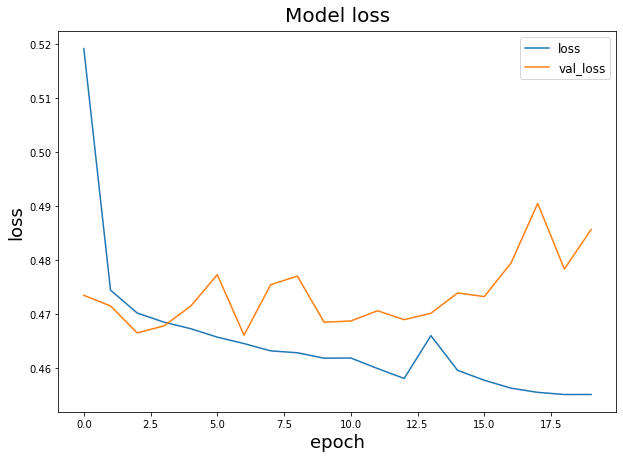

In [8]:
# summarize history for loss
plt.figure(figsize=(10, 7))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss', fontsize=20,  pad=10)

plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)

plt.legend(['loss', 'val_loss'], loc='upper right', fontsize=12)

plt.show()

In [9]:
#######################################################################################################################
# Import relevant Keras classes

# Input layer 
from keras.layers import InputLayer, Input
# The Dense Layer
from keras.layers import Dense
# Utilities
from keras.layers import Flatten, MaxPooling1D, Dropout, AveragePooling1D, GlobalAveragePooling1D, Reshape

# Sequential class for instantiating the Model
from keras.models import Sequential
from keras import Model # If we want to use the Keras API

# To get the Activation functions
from keras.layers import Activation


#######################################################################################################################
# Input-Output defs

input_shape = np.shape(X_train)[1]   # Input layer takes [number of vectors, size of vectors, features-per-vector] = [#size_dataset, 1000, 1]
num_classes = 3 # RGB

CHANNEL_DEPTH = 500   # Each histograms has 500 channels
num_sensors = 1       # We have only 1 histogram per data

#######################################################################################################################
# Defining the model
#######################################################################################################################

# Instantiate it
model_d = Sequential()

#############
# input
model_d.add(Input(shape=(input_shape, )))

#############
# Hidden Layers

# 1°
model_d.add(Dense(128,
                 activation='relu'))
model_d.add(Dropout(0.2))

# 2°
model_d.add(Dense(256,
                 activation='relu'))
model_d.add(Dropout(0.4))

# 3° 
model_d.add(Dense(128,
                 activation='relu'))
model_d.add(Dropout(0.2))

# 4° 
model_d.add(Dense(256,
                 activation='relu'))
model_d.add(Dropout(0.4))

# 5°
model_d.add(Dense(128,
                 activation='relu'))
model_d.add(Dropout(0.2))

# Output layer
model_d.add(Dense(num_classes, activation='sigmoid'))

###########
# Summary
print(model_d.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               64128     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)              

In [10]:
############################
# Training - prerequisites
loss_used = 'binary_crossentropy'

model_d.compile(loss=loss_used,
                 optimizer='adam',
                 )
# We need to pick the size of the batch used for the training
BATCH_SIZE = 200 
# And the number of epochs on which we train the dataset
EPOCHS = 20 

import datetime
starting_time = datetime.datetime.now() 

print('\nStart training model: \n')

##########################################################
# TRAINING

history_d = model_d.fit(X_train,
                       y_train,
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       #callbacks=callbacks_list,
                       validation_data=(X_test, y_test),
                       verbose=1)

print('\n\nTraining done...\n')

now = datetime.datetime.now()
total_training_time = now-starting_time
print('Total training time: ', total_training_time)


Start training model: 

Epoch 1/20
104/104 [==============================] - 2s 13ms/step - loss: 0.7718 - val_loss: 0.5176
Epoch 2/20
104/104 [==============================] - 1s 11ms/step - loss: 0.5021 - val_loss: 0.4950
Epoch 3/20
104/104 [==============================] - 1s 12ms/step - loss: 0.4910 - val_loss: 0.4849
Epoch 4/20
104/104 [==============================] - 1s 12ms/step - loss: 0.4846 - val_loss: 0.4900
Epoch 5/20
104/104 [==============================] - 1s 12ms/step - loss: 0.4843 - val_loss: 0.4756
Epoch 6/20
104/104 [==============================] - 1s 12ms/step - loss: 0.4782 - val_loss: 0.4725
Epoch 7/20
104/104 [==============================] - 1s 12ms/step - loss: 0.4769 - val_loss: 0.4752
Epoch 8/20
104/104 [==============================] - 1s 11ms/step - loss: 0.4767 - val_loss: 0.4711
Epoch 9/20
104/104 [==============================] - 1s 12ms/step - loss: 0.4734 - val_loss: 0.4708
Epoch 10/20
104/104 [==============================] - 1s 12ms/ste

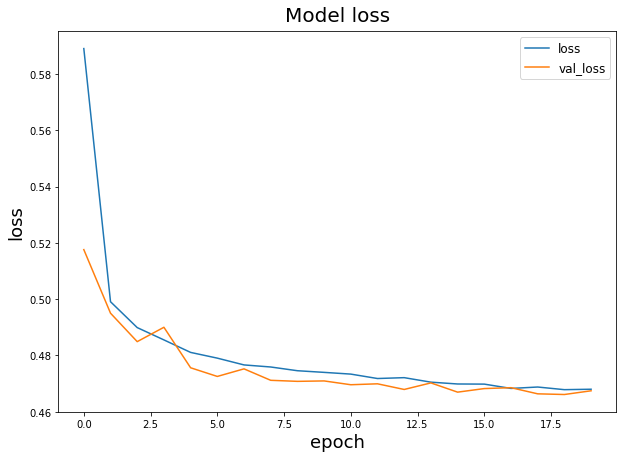

In [11]:
# summarize history for loss
plt.figure(figsize=(10, 7))

plt.plot(history_d.history['loss'])
plt.plot(history_d.history['val_loss'])

plt.title('Model loss', fontsize=20,  pad=10)

plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)

plt.legend(['loss', 'val_loss'], loc='upper right', fontsize=12)

plt.show()

Shape of the loaded XRF image: (255, 141, 500)
Shape of the loaded RGB image (true): (258, 141, 3)


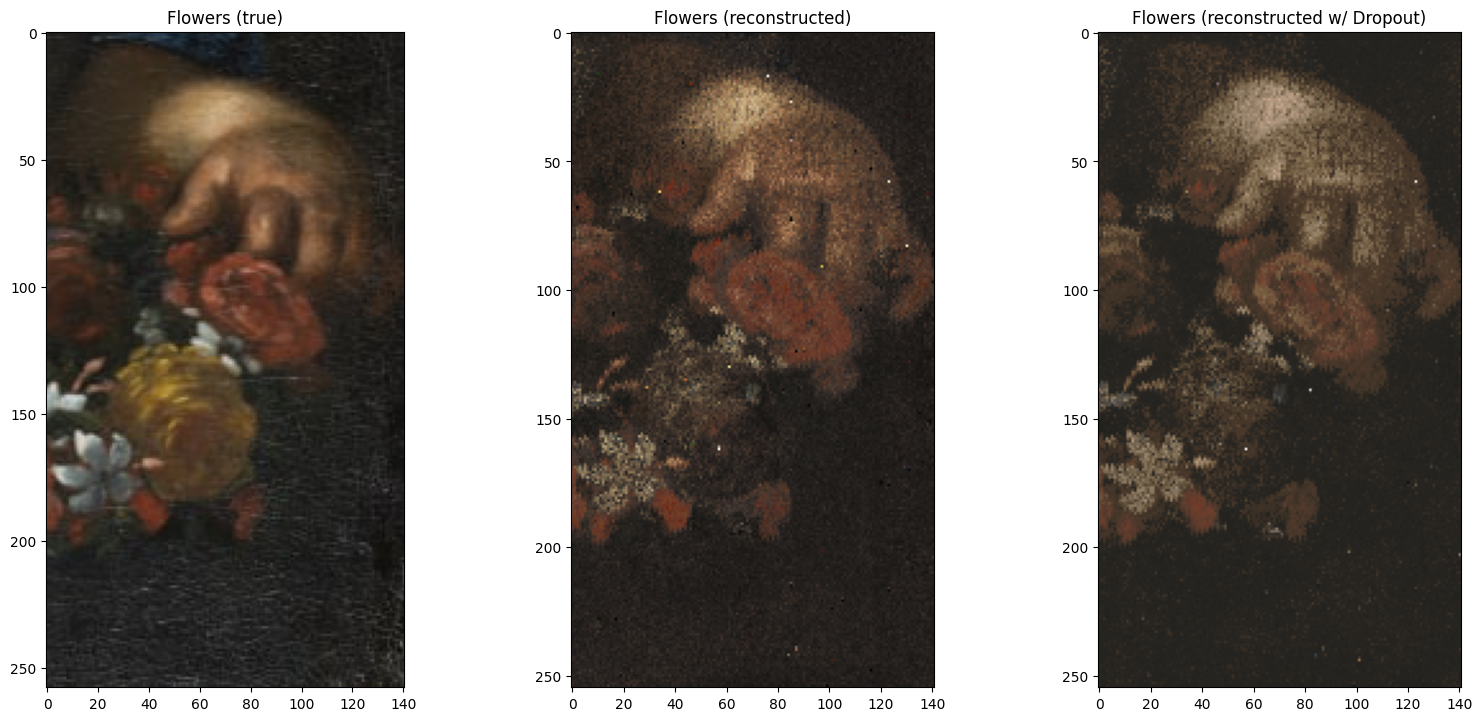

In [18]:
import PIL
filename = "Rawdata+RGB/Putto_Area1_fiori"
xrf_img = np.load(f"{filename}.npz")['img']
print (f"Shape of the loaded XRF image: {xrf_img.shape}")
true_img = np.asarray(PIL.Image.open(f"{filename}.jpg"))
print (f"Shape of the loaded RGB image (true): {true_img.shape}")

pixels = xrf_img.reshape ((-1, 500))
rgb_pred = model_m.predict (pixels).reshape (xrf_img[:,:,:3].shape)
rgb_pred_d = model_d.predict (pixels).reshape (xrf_img[:,:,:3].shape)



plt.figure(figsize=(16,16), dpi=100)
plt.subplot(231)
plt.title ("Flowers (true)")
plt.imshow ( true_img )
plt.subplot(232)
plt.title ("Flowers (reconstructed)")
plt.imshow ( np.flip(rgb_pred, 1) )
plt.subplot(233)
plt.title ("Flowers (reconstructed w/ Dropout)")
plt.imshow ( np.flip(rgb_pred_d, 1) )
plt.tight_layout()
# Make space for title
plt.subplots_adjust(top=0.85)
plt.show()

## Exercise 2: Deep CNN; hints from ImageNet Large Scale Visual Recognition Challenge winners - AlexNet & VGG

The **ImageNet** project is a large visual database designed for use in visual object recognition software research. More than 14 million images have been hand-annotated by the project. 

Since 2010, a competition was launch, dubbed *ImageNet Large Scale Visual Recognition Challenge* (ILSVRC), where researchers from all around the globe have to design a novel Deep Learning architecture to label the dataset. From the ImageNet homepage [1]:

*The ImageNet Large Scale Visual Recognition Challenge (ILSVRC) evaluates algorithms for object detection and image classification at large scale. One high level motivation is to allow researchers to compare progress in detection across a wider variety of objects -- taking advantage of the quite expensive labeling effort. Another motivation is to measure the progress of computer vision for large scale image indexing for retrieval and annotation.*

### AlexNet

On 30 September 2012, a convolutional neural network (CNN) called **AlexNet** [3] achieved a top-5 error of 15.3% in the ImageNet 2012 Challenge, more than 10.8 percentage points lower than that of the runner up. 

AlexNet is considered one of the most influential papers published in computer vision, having spurred many more papers published employing CNNs and GPUs to accelerate deep learning. As of 2021, the AlexNet paper has been cited over 80,000 times according to Google Scholar. 

<img src="./Assets/Images/AlexNet.png" alt="Drawing" style="float: center; margin-top: 15px"/>

AlexNet contained eight layers; the first five were convolutional layers, some of them followed by max-pooling layers, and the last three were fully connected layers. It used the non-saturating ReLU activation function, which showed improved training performance over tanh and sigmoid. In detail [3]:

- 1 Convolutional layer with kernel size (11,11) and 96 filters, followed by a (3,3)-MaxPooling;
- 1 Convolutional layer with kernel size (5,5) and 256 filters, followed by a (3,3)-MaxPooling;
- 1 Convolutional layer with kernel size (3,3) and 128 filters;
- 2 Convolutional layers with kernel size (3,3) and 192 filters each, followed by a Flatten layer to feed the dense layer;
- 2 Dense layers with 4096 neurons and a 0.5-probability drop layer (see ex.1)
- the Output layer which may label 10 categories.

In code [4]: 

```
AlexNet_model = keras.models.Sequential(
    [
    # 1°: (11x11)
    keras.layers.Conv2D(filters=96, 
                            kernel_size=(11,11), strides=(4,4), activation='relu', 
                            input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

    # 2° (5x5)
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

    # 3,4,5° (3x3)
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization()
    ,
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),

    # Dense layers
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),

    # Output
    keras.layers.Dense(10, activation='softmax')
    ]
)
```

### VGG

In 2014, a novel architecture developed by the Oxford's *Visual Geometry Group* (VGG), dubbed *Very Deep Convolutional Networks for Large-Scale Visual Recognition* (shortened in VGG-16) was presented at ILSVRC; citing the VGG page [5] 

*Our main contribution is a rigorous evaluation of networks of increasing depth, which shows that a significant improvement on the prior-art configurations can be achieved by increasing the depth to 16-19 weight layers, which is substantially deeper than what has been used in the prior art. To reduce the number of parameters in such very deep networks, we use very small 3×3 filters in all convolutional layers (the convolution stride is set to 1). Please see our publication for more details.*

*The very deep ConvNets were the basis of our ImageNet ILSVRC-2014 submission, where our team (VGG) secured the first and the second places in the localisation and classification tasks respectively.*

<img src="./Assets/Images/VGG163d.png" alt="Drawing" style="float: center; margin-top: 15px"/>

The VGG architecture (in his base form, VGG-16, and its evolution, VGG-19) is [6]:

<img src="./Assets/Images/VGG1619.png" alt="Drawing" style="float: center; margin-top: 15px; width: 50%"/>

### EXERCISE:

Choose one of the two architectures, and write down an analougus 1-dimensional model. Keep the numbers low, you should avoid either overfitting (see ex.1) as well as a too long training time. 

After that, try adapting the various (hyper)parameters to lower the loss, and, when you find something plausible, try to recolor the XRF image, as in the lecture. 

-------------------
[1] https://image-net.org/challenges/LSVRC/

[2] O. Russakovsky et al., *ImageNet Large Scale Visual Recognition Challenge* https://arxiv.org/abs/1409.0575

[3] A. Krizhevsky, I. Sutskever, G. E. Hinton, *ImageNet Classification with Deep ConvolutionalNeural Networks*, doi:10.1145/3065386 https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

[4] https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

[5] https://www.robots.ox.ac.uk/~vgg/research/very_deep/

[6] K. Simonyan, A. Zisserman, *Very Deep Convolutional Networks for Large-Scale Image Recognition*, https://arxiv.org/abs/1409.1556

For an extensive recap on ILSVRC and more: https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5

### AlexNet

In [20]:
from keras.layers import InputLayer, Conv1D, Dense, Flatten, MaxPooling1D, Dropout, AveragePooling1D, GlobalAveragePooling1D, Reshape
from keras.models import Sequential
from keras.layers import concatenate, BatchNormalization, Input, Add, Activation
from keras import Model

from keras.layers import PReLU
from keras.initializers import Constant

#######################################################################################################################
# Input

input_shape = np.shape(X_train)[1]   # Input layer takes [number of vectors, size of vectors, features-per-vector] = [#size_dataset, 1000, 1]
num_classes = 3 # RGB

CHANNEL_DEPTH = 500
num_sensors = 1


#############
# input
inputs = Input(shape=(input_shape, ))
x = Reshape( (CHANNEL_DEPTH, num_sensors), input_shape=(input_shape, )) (inputs)


#############
# CNN entry part; 3x (2xConv1D + BatchNorm + MaxPool)

# 1° 1x11
x = Conv1D(filters=8, kernel_size=11, activation='relu', 
                   input_shape = (CHANNEL_DEPTH, num_sensors)
                  )(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x) 


# 2° 1x5
x = Conv1D(filters=16, kernel_size=5, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)


# 3° 1x2 + 2x3
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)


#############
# Flatten
x = Flatten()(x)

# #############
# #  Fully Connected layers
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

#############
#  Last layer - output
outputs = Dense(num_classes, activation='sigmoid')(x)


# Final model definition
AlexNet_model = Model(inputs=inputs, outputs=outputs, name="AlexNet")

print(AlexNet_model.summary())

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 500, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 490, 8)            96        
_________________________________________________________________
batch_normalization_5 (Batch (None, 490, 8)            32        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 245, 8)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 241, 16)           656       
_________________________________________________________________
batch_normalization_6 (Batch (None, 241, 16)           64  

In [21]:
############################
# Training - prerequisites
loss_used = 'binary_crossentropy'

AlexNet_model.compile(loss=loss_used,
                 optimizer='adam',
                 )
# We need to pick the size of the batch used for the training
BATCH_SIZE = 200 
# And the number of epochs on which we train the dataset
EPOCHS = 20

import datetime
starting_time = datetime.datetime.now() 

print('\nStart training model: \n')

##########################################################
# TRAINING

history_AlexNet = AlexNet_model.fit(X_train,
                       y_train,
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       #callbacks=callbacks_list,
                       validation_data=(X_test, y_test),
                       verbose=1)

print('\n\nTraining done...\n')

now = datetime.datetime.now()
total_training_time = now-starting_time
print('Total training time: ', total_training_time)


Start training model: 

Epoch 1/20
104/104 [==============================] - 10s 77ms/step - loss: 0.5482 - val_loss: 0.5404
Epoch 2/20
104/104 [==============================] - 7s 68ms/step - loss: 0.4888 - val_loss: 0.4921
Epoch 3/20
104/104 [==============================] - 7s 69ms/step - loss: 0.4798 - val_loss: 0.4819
Epoch 4/20
104/104 [==============================] - 7s 69ms/step - loss: 0.4772 - val_loss: 0.4709
Epoch 5/20
104/104 [==============================] - 7s 71ms/step - loss: 0.4758 - val_loss: 0.4757
Epoch 6/20
104/104 [==============================] - 7s 70ms/step - loss: 0.4757 - val_loss: 0.4825
Epoch 7/20
104/104 [==============================] - 7s 71ms/step - loss: 0.4714 - val_loss: 0.4802
Epoch 8/20
104/104 [==============================] - 8s 73ms/step - loss: 0.4721 - val_loss: 0.4747
Epoch 9/20
104/104 [==============================] - 7s 69ms/step - loss: 0.4696 - val_loss: 0.4701
Epoch 10/20
104/104 [==============================] - 7s 69ms/st

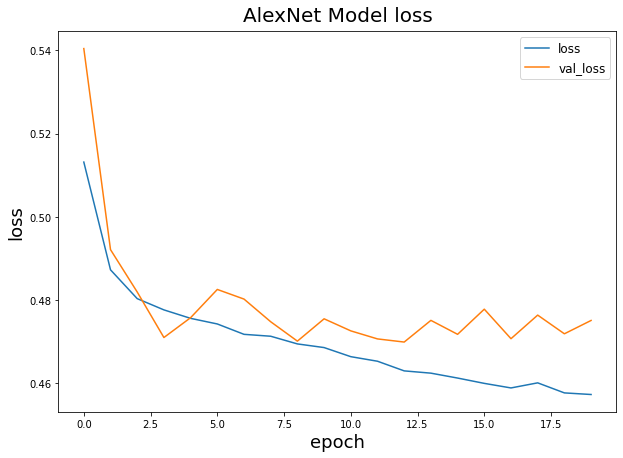

In [22]:
# summarize history for loss
plt.figure(figsize=(10, 7))

plt.plot(history_AlexNet.history['loss'])
plt.plot(history_AlexNet.history['val_loss'])

plt.title('AlexNet Model loss', fontsize=20,  pad=10)

plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)

plt.legend(['loss', 'val_loss'], loc='upper right', fontsize=12)

plt.show()

In [24]:
rgb_pred_AlexNet = AlexNet_model.predict (pixels).reshape (xrf_img[:,:,:3].shape)   

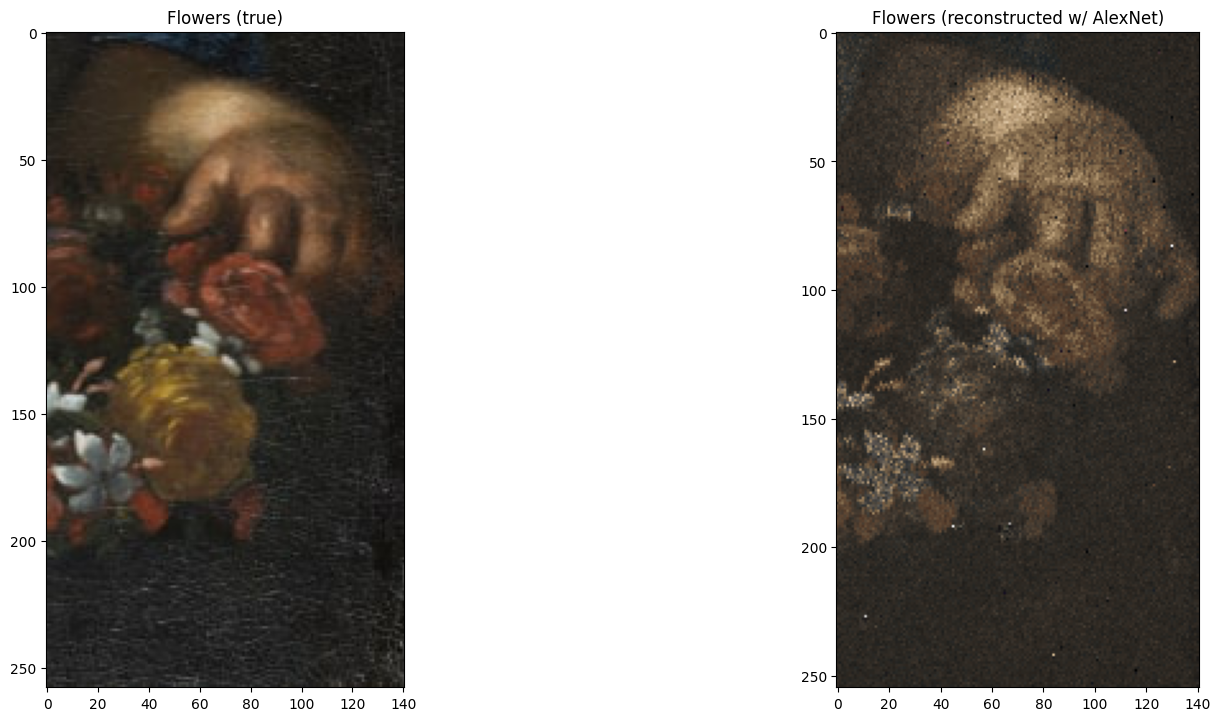

In [26]:
plt.figure(figsize=(16,16), dpi=100)
plt.subplot(221)
plt.title ("Flowers (true)")
plt.imshow (true_img)
plt.subplot(222)
plt.title ("Flowers (reconstructed w/ AlexNet)")
plt.imshow (np.flip( rgb_pred_AlexNet, 1) )

plt.tight_layout()
# Make space for title
plt.subplots_adjust(top=0.85)
plt.show()

### VGG-16

In [27]:
from keras.layers import InputLayer, Conv1D, Dense, Flatten, MaxPooling1D, Dropout, AveragePooling1D, GlobalAveragePooling1D, Reshape
from keras.models import Sequential
from keras.layers import concatenate, BatchNormalization, Input, Add, Activation
from keras import Model

from keras.layers import PReLU
from keras.initializers import Constant

#######################################################################################################################
# Input

input_shape = np.shape(X_train)[1]   # Input layer takes [number of vectors, size of vectors, features-per-vector] = [#size_dataset, 1000, 1]
num_classes = 3 # RGB

CHANNEL_DEPTH = 500
num_sensors = 1


#############
# input
inputs = Input(shape=(input_shape, ))
x = Reshape( (CHANNEL_DEPTH, num_sensors), input_shape=(input_shape, )) (inputs)

# We riduce the parameters by a factor of 8 for each layer

#############
# CNN entry part; 3x (2xConv1D + BatchNorm + MaxPool)

# 1° 2 Conv + 1 Pool
x = Conv1D(filters=8, kernel_size=3, activation='relu', 
                   input_shape = (CHANNEL_DEPTH, num_sensors)
                  )(x)
x = Conv1D(filters=8, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(2)(x) 


# 2° 2 Conv + 1 Pool
x = Conv1D(filters=16, kernel_size=3, activation='relu')(x)
x = Conv1D(filters=16, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(2)(x)


# 3° 2 Conv + 1 Pool
x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(2)(x)

# 4° 3 Conv + 1 Pool
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(2)(x)

# 5° 3 Conv + 1 Pool
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(2)(x)

#############
# Flatten
x = Flatten()(x)

# #############
# #  Fully Connected layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)


#############
#  Last layer - output
outputs = Dense(num_classes, activation='sigmoid')(x)


# Final model definition
VGG16_model = Model(inputs=inputs, outputs=outputs, name="VGG-16")

print(VGG16_model.summary())

Model: "VGG-16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 500, 1)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 498, 8)            32        
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 496, 8)            200       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 248, 8)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 246, 16)           400       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 244, 16)           784  

In [28]:
############################
# Training - prerequisites
loss_used = 'binary_crossentropy'

VGG16_model.compile(loss=loss_used,
                 optimizer='adam',
                 )
# We need to pick the size of the batch used for the training
BATCH_SIZE = 200 
# And the number of epochs on which we train the dataset
EPOCHS = 20

import datetime
starting_time = datetime.datetime.now() 

print('\nStart training model: \n')

##########################################################
# TRAINING

history_VGG16 = VGG16_model.fit(X_train,
                       y_train,
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       #callbacks=callbacks_list,
                       validation_data=(X_test, y_test),
                       verbose=1)

print('\n\nTraining done...\n')

now = datetime.datetime.now()
total_training_time = now-starting_time
print('Total training time: ', total_training_time)


Start training model: 

Epoch 1/20
104/104 [==============================] - 8s 67ms/step - loss: 0.5397 - val_loss: 0.4790
Epoch 2/20
104/104 [==============================] - 6s 61ms/step - loss: 0.4846 - val_loss: 0.4737
Epoch 3/20
104/104 [==============================] - 6s 61ms/step - loss: 0.4782 - val_loss: 0.4699
Epoch 4/20
104/104 [==============================] - 6s 60ms/step - loss: 0.4738 - val_loss: 0.4676
Epoch 5/20
104/104 [==============================] - 6s 59ms/step - loss: 0.4739 - val_loss: 0.4689
Epoch 6/20
104/104 [==============================] - 6s 59ms/step - loss: 0.4718 - val_loss: 0.4660
Epoch 7/20
104/104 [==============================] - 6s 61ms/step - loss: 0.4708 - val_loss: 0.4653
Epoch 8/20
104/104 [==============================] - 6s 60ms/step - loss: 0.4685 - val_loss: 0.4660
Epoch 9/20
104/104 [==============================] - 6s 61ms/step - loss: 0.4702 - val_loss: 0.4672
Epoch 10/20
104/104 [==============================] - 6s 62ms/ste

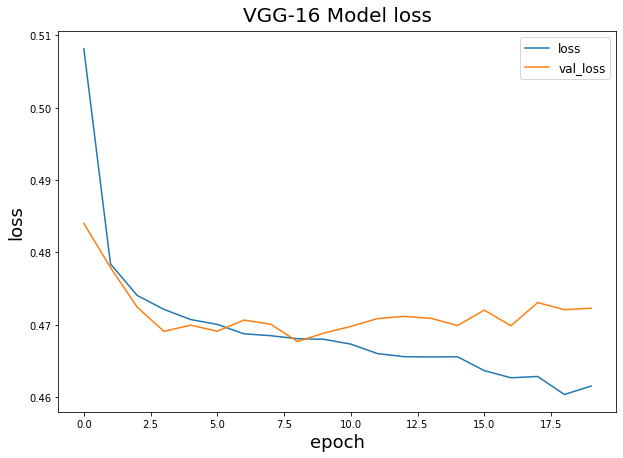

In [15]:
# summarize history for loss
plt.figure(figsize=(10, 7))

plt.plot(history_VGG16.history['loss'])
plt.plot(history_VGG16.history['val_loss'])

plt.title('VGG-16 Model loss', fontsize=20,  pad=10)

plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)

plt.legend(['loss', 'val_loss'], loc='upper right', fontsize=12)

plt.show()

In [29]:
rgb_pred_VGG16 = VGG16_model.predict (pixels).reshape (xrf_img[:,:,:3].shape)   

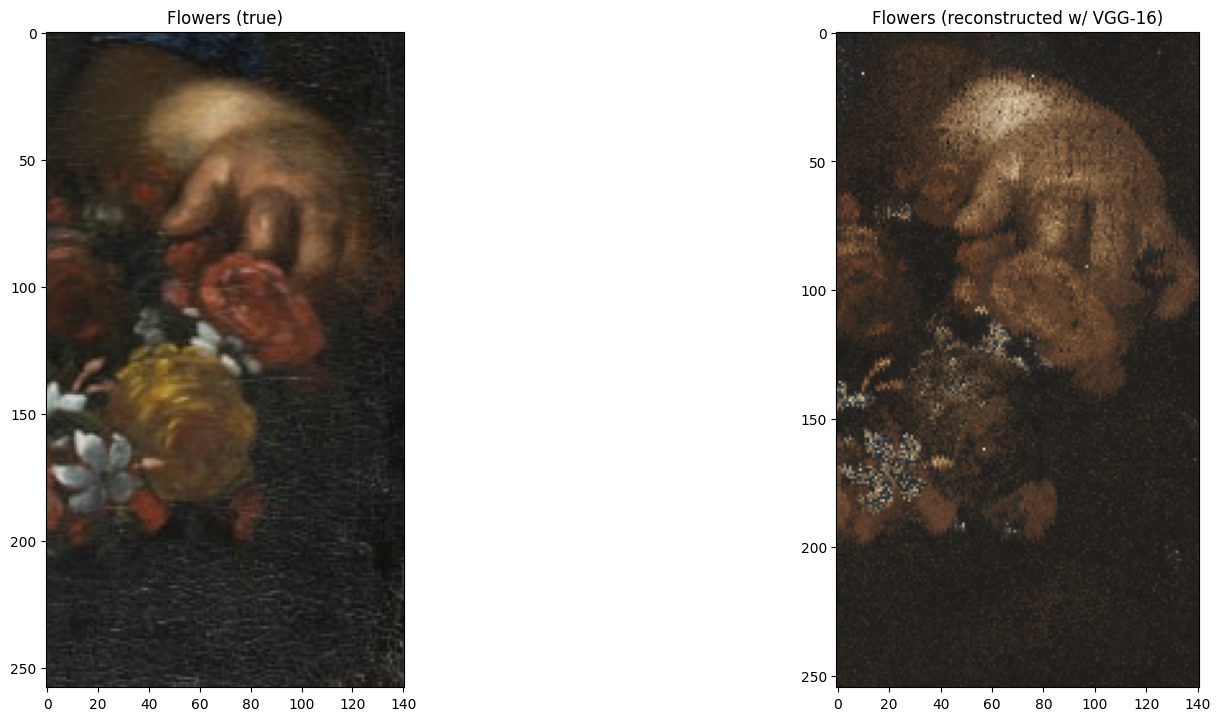

In [30]:
plt.figure(figsize=(16,16), dpi=100)
plt.subplot(221)
plt.title ("Flowers (true)")
plt.imshow (true_img)
plt.subplot(222)
plt.title ("Flowers (reconstructed w/ VGG-16)")
plt.imshow (np.flip( rgb_pred_VGG16, 1) )

plt.tight_layout()
# Make space for title
plt.subplots_adjust(top=0.85)
plt.show()

## Exercise 3: Design your own DNN

**EXERCISE**

Build your own Deep Neural Network. Use anything you like from the lecture. 

PS: a suggestion: try to use the keras functional API, and a non-linear topology. Google "Deep Learning" + a title of a famous Christopher Nolan's movie with Di Caprio and Joseph Gordon-Levitt. It could give you inspiration. 
<img src="./Assets/Images/inception_film.jpg" alt="Drawing" style="float: center; margin-top: 15px"/>